## Week 12 MCD Technical Factor Test

### **Import Libraries**

In [1]:
# import needed libraries
import numpy as np
from numpy import loadtxt
from pandas_datareader import data, wb
import datetime
import holidays
from dateutil.relativedelta import relativedelta
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### **Data Preprocessing**

In [2]:
def data_preparation(path):
    factor_df = pd.read_csv(path)
    # remove non-rank columns 
    columns = factor_df.columns.drop(['End of Month', 'PERMNO', 'GVKEY', 'Point-in-time CUSIP', 'Point-in-time Ticker', 'Point-in-time Name', 'Last Known CUSIP', 'Last Known Ticker', 'Last Known Name'])
    factor_df = factor_df[columns]
    
    # Convert CalendarDate into datatime format
    factor_df['Date'] =  pd.to_datetime(factor_df['Calendar Date'], format='%Y%m%d')
    factor_df = factor_df.drop(['Calendar Date'], axis=1)
    # create a new dataframe with 'CalendarDate' column as index
    factor_df = factor_df.set_index('Date')
    
    # handling missing data
    factor_df[factor_df=='.'] = pd.np.nan 
    factor_df = factor_df.astype(float)
    
    # remove columns contains nan
    factor_df = factor_df.dropna(axis=1, how='any')
      
    return factor_df
    
MCD_tech_factor_df = data_preparation('tech_factor_data/MCD_tech_inputs_daily_quintile_ranks_s2000.csv')
MCD_tech_factor_df.head()

,One-Week Daily Price Trend,One-Month Daily Price Trend,Three-Month Daily Price Trend,Nine-Month Daily Price Trend,Nine-Month Daily Return Skewness,Nine-Month Share of Days Outperforming,Average Daily Share Turnover,One-Month Change in Average Daily Share Turnover,Stochastic Oscillator,Relative Strength Index,...,Arbitrage Risk,One-Month Change in Arbitrage Risk,Daily Media Sentiment Indicator,Downside Risk (Measured Over the Trailing Three Months),Downside Risk (Measured Over the Trailing Six Months),Downside Risk (Measured Over the Trailing Nine Months),Downside Risk (Measured Over the Trailing Twelve Months),Change in Downside Risk (Measured Over the Trailing Twelve Months),Interaction of Supernovas and Nine-Month Price Trend,Interaction of Earnings Growth Stability and Arbitrage Risk
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5.0,5.0,5.0,4.0,5.0,4.0,1.0,3.0,1.0,1.0,...,2.0,3.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0
2000-01-04,4.0,5.0,4.0,4.0,5.0,4.0,1.0,3.0,1.0,1.0,...,2.0,3.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0
2000-01-05,3.0,5.0,4.0,4.0,5.0,4.0,1.0,3.0,1.0,1.0,...,2.0,3.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
2000-01-06,2.0,5.0,4.0,4.0,5.0,4.0,1.0,4.0,1.0,1.0,...,2.0,2.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
2000-01-07,3.0,5.0,4.0,4.0,5.0,4.0,1.0,4.0,2.0,1.0,...,2.0,2.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0


In [3]:
MCD_tech_factor_df.columns

Index(['One-Week Daily Price Trend', 'One-Month Daily Price Trend',
       'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend',
       'Nine-Month Daily Return Skewness',
       'Nine-Month Share of Days Outperforming',
       'Average Daily Share Turnover',
       'One-Month Change in Average Daily Share Turnover',
       'Stochastic Oscillator', 'Relative Strength Index', 'Bollinger Band',
       'MACD Signal', 'Technical Indicator', 'Earnings Revision',
       'Three-Month Smoothed Earnings Revision', 'Estimate Dispersion',
       'Share of Estimates Rising', 'Three-Month Smoothed Dollar Volume',
       'Arbitrage Risk', 'One-Month Change in Arbitrage Risk',
       'Daily Media Sentiment Indicator',
       'Downside Risk (Measured Over the Trailing Three Months)',
       'Downside Risk (Measured Over the Trailing Six Months)',
       'Downside Risk (Measured Over the Trailing Nine Months)',
       'Downside Risk (Measured Over the Trailing Twelve Months)',
       'Change

### **Variance Test for Technical Factors**

In [4]:
var_thres = 0.2
def variance_feature_selection(factor_df, var_thres):
    selector = VarianceThreshold(var_thres)
    fit = selector.fit_transform(factor_df)
    dfvariances = pd.DataFrame(selector.variances_)
    dfcolumns = pd.DataFrame(factor_df.columns)
    #concat two dataframes for better visualization 
    featureVariances = pd.concat([dfcolumns,dfvariances],axis=1)
    featureVariances.columns = ['Factor','Variance']  #naming the dataframe columns
    print(featureVariances.nlargest(34,'Variance'))  #print 10 best features
    
    
    return factor_df[factor_df.columns[selector.get_support(indices=True)]]

### **Technical Factor Selection**

In [5]:
var_MCD_tech_factor_df = variance_feature_selection(MCD_tech_factor_df, var_thres)

                                               Factor  Variance
16                          Share of Estimates Rising  2.744057
20                    Daily Media Sentiment Indicator  2.292611
8                               Stochastic Oscillator  2.091829
4                    Nine-Month Daily Return Skewness  2.057220
9                             Relative Strength Index  2.054293
3                        Nine-Month Daily Price Trend  1.955172
12                                Technical Indicator  1.942745
25  Change in Downside Risk (Measured Over the Tra...  1.823402
5              Nine-Month Share of Days Outperforming  1.812369
0                          One-Week Daily Price Trend  1.672102
2                       Three-Month Daily Price Trend  1.660301
11                                        MACD Signal  1.651661
19                 One-Month Change in Arbitrage Risk  1.567939
1                         One-Month Daily Price Trend  1.564026
13                                  Earn

In [6]:
sns.set_context('notebook', font_scale=2)

def plot_one_column(df, column_name):
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    gx.plot(df.index, df[column_name], color='blue', label=column_name)
    gx.set_xlabel('Dates',size=40, fontsize=40)
#     gx.set_ylabel('Quintile Rank', fontsize=20)
    gx.set_title(column_name, size=40)
    # other parameters
    gx.grid(True)

### **Function to Generate real-time labels**

In [7]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

# function to return the date of n bussiness days before the test date 
def n_business_day_before(test_date, n):
    last_day = test_date
    for _ in range(n):
        last_day = last_day - ONE_DAY
        while last_day.weekday() in holidays.WEEKEND or last_day in HOLIDAYS_US:
            last_day -= ONE_DAY
    return last_day 

def up_down_threshold(df, train_start_date, test_date, pred_day):
    '''
    df: dataframe contains ReturnNDays column
    '''   
    train_end_date = n_business_day_before(test_date, pred_day)
    dataset_mask = (df.index>=train_start_date) & (df.index<=train_end_date)
    return_list = df['Return{}Days'.format(pred_day)].loc[dataset_mask].tolist()
    sorted_return_list = sorted(return_list, key=float)
#     print(sorted_return_list)
    down_thres_index = int(len(sorted_return_list)/3 + 1)
    up_thres_index = down_thres_index * 2 
    down_thres, up_thres = sorted_return_list[down_thres_index], sorted_return_list[up_thres_index]
    return down_thres, up_thres

def generate_NDayReturn(factor_df, ticker_name, start_date, end_date, pred_day):
    price_df = data.DataReader(ticker_name, 'yahoo', start_date, end_date)
    price_df = price_df[['Adj Close']]
    df = pd.merge(factor_df, price_df, on='Date')

    # obtain n day return percent in the future 
    df['Return{}Days'.format(pred_day)] = df['Adj Close'].pct_change(pred_day).shift(-pred_day)  
    # remove the last n days NaN returns
    df = df[:-pred_day]
    
    # remove 'Adj Close' columns
    columns = df.columns.drop(['Adj Close'])
    df = df[columns]
    
    return df

# function to generate dir labels real time based on the shifting input training window balance 
def generate_labels_real_time(df, pred_day, train_start, test_date):
     
    # calculate training set up/down thresholds
    down_thres, up_thres = up_down_threshold(df, train_start, test_date, pred_day)
    
    # Obtain 'DirNDays' column based on thresholds
    df['Dir{}Days'.format(pred_day)] = 'neu'
    df.loc[df['Return{}Days'.format(pred_day)]>up_thres, 'Dir{}Days'.format(pred_day)] = 'pos'
    df.loc[df['Return{}Days'.format(pred_day)]<down_thres, 'Dir{}Days'.format(pred_day)] = 'neg'

    # remove 'Return5Days' and 'Adj Close' columns
    columns = df.columns.drop(['Return{}Days'.format(pred_day)])
    df = df[columns]

    #Creating the dependent variable class
    # 'neg': 0, 'neu': 1, 'pos': 2
    le = LabelEncoder()
    df['Dir{}Days'.format(pred_day)] = le.fit_transform(df['Dir{}Days'.format(pred_day)])
    df = df.astype(float)
    df = df.astype({'Dir{}Days'.format(pred_day): int})
    
    return df 

### **Function for Model Building**

In [8]:
def model_testing(df, test_date_start, history_window, pred_day, model_name):
    
    test_dates = df.loc[test_date_start:].index.tolist()
    y_true = []
    y_pred = []
    
    # select ml model 
    if model_name == 'LR':
        model = LogisticRegression()
        
#         model = LogisticRegression(penalty='l1', C=10, solver='liblinear')
    elif model_name == 'NB':
        model = GaussianNB()
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators = 8, criterion = 'entropy', random_state = 42)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=12)
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=200,algorithm="SAMME.R", learning_rate=0.1, random_state=0)
    
    for test_date in test_dates:
        # create training and testing set
        train_start = test_date - history_window
#         print('test_date: {t} \t train_end: {e}'.format(t=test_date, e=train_end))
        real_time_df = generate_labels_real_time(df, pred_day, train_start, test_date)
        
        # dataset will include test_date data also
        dataset = real_time_df.loc[train_start:test_date]
        # training set last label should be current test_date 
        train_set = dataset[:-pred_day].values
        test_set = dataset.loc[test_date].values
        X_train, y_train = train_set[:, :-1], train_set[:, -1]
        X_test, y_test = test_set[:-1].reshape(1,-1), test_set[-1]
        
        # training and testing 
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        
#     label_plot(real_time_df,'Dir{}Days Distribution'.format(pred_day), train_start, test_date, pred_day)
    
    y_true, y_pred = np.array(y_true), np.array(y_pred).transpose().flatten()

    return y_true, y_pred, test_dates

#### **Function for Model Performance Evaluation**

In [9]:
def model_performance(y_test, y_pred, model_name):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    performance_df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return performance_df 

def error_distance_count(y_test, y_pred):
    error_distance = np.absolute(y_test - y_pred)
    unique, counts = np.unique(error_distance, return_counts=True)
    counts = counts / len(y_test)
    error_dic = dict(zip(unique, counts))
    return error_dic 

def plot_error_distance(y_test, y_pred, title):
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    
    error_dic = error_distance_count(y_test, y_pred)
    plt.xlabel('Error Distance')
    plt.ylabel('Error Rate')
    plt.title(title, loc='center')
    plt.bar(list(error_dic.keys()), error_dic.values(), color='g')
    plt.show()    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-white')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot predictions vs observations
def plot_pred_perform(y_true, y_pred, test_dates, title):
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.5)
    plt.style.use('seaborn-whitegrid')
    plt.scatter(test_dates, y_true,s=50, c='r', alpha=0.8, label='True Dir', edgecolor='none')
    plt.scatter(test_dates, y_pred, s=50, c='b', alpha=0.3, label='Predict Dir', edgecolor='none')
    plt.title(title)
    plt.ylabel('Direction Label')
#     plt.xticks(rotation=45)
    plt.xlabel('Date')
#     plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# function return univariate distributions of Dir5Days
def label_plot(df, title, start_date, end_date, pred_day):
    dataset_mask = (df.index>start_date) & (df.index<end_date)
#     date_start = test_date_start - history_window
#     dataset_mask = (df.index>date_start) 
    dataset = df.loc[dataset_mask]
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    sns.countplot(dataset['Dir{}Days'.format(pred_day)],palette='Set1')
    plt.title(title, loc='center')
    plt.tight_layout()
    plt.show()
    
def model_evalutation(y_true, y_pred, test_dates, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(ticker_name))
    plot_error_distance(y_true, y_pred, 'Error Performance for {}'.format(model_name))
    performance = model_performance(y_true, y_pred, model_name)
    plot_pred_perform(y_true, y_pred, test_dates, 'Prediction Performance for {}'.format(model_name))
    print(performance)
    return performance

#### **Model Test**

In [10]:
for factor in MCD_tech_factor_df.columns:
    print(factor)

One-Week Daily Price Trend
One-Month Daily Price Trend
Three-Month Daily Price Trend
Nine-Month Daily Price Trend
Nine-Month Daily Return Skewness
Nine-Month Share of Days Outperforming
Average Daily Share Turnover
One-Month Change in Average Daily Share Turnover
Stochastic Oscillator
Relative Strength Index
Bollinger Band
MACD Signal
Technical Indicator
Earnings Revision
Three-Month Smoothed Earnings Revision
Estimate Dispersion
Share of Estimates Rising
Three-Month Smoothed Dollar Volume
Arbitrage Risk
One-Month Change in Arbitrage Risk
Daily Media Sentiment Indicator
Downside Risk (Measured Over the Trailing Three Months)
Downside Risk (Measured Over the Trailing Six Months)
Downside Risk (Measured Over the Trailing Nine Months)
Downside Risk (Measured Over the Trailing Twelve Months)
Change in Downside Risk (Measured Over the Trailing Twelve Months)
Interaction of Supernovas and Nine-Month Price Trend
Interaction of Earnings Growth Stability and Arbitrage Risk


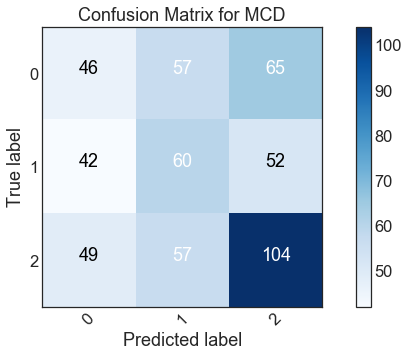

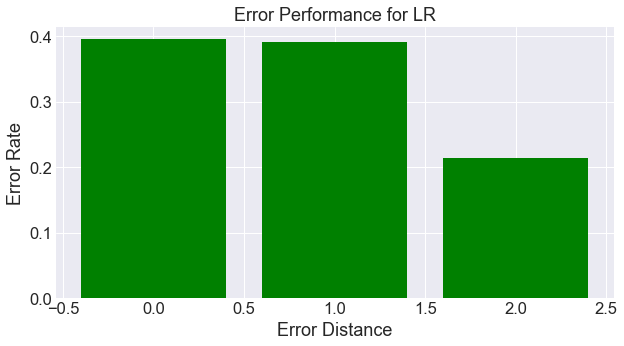

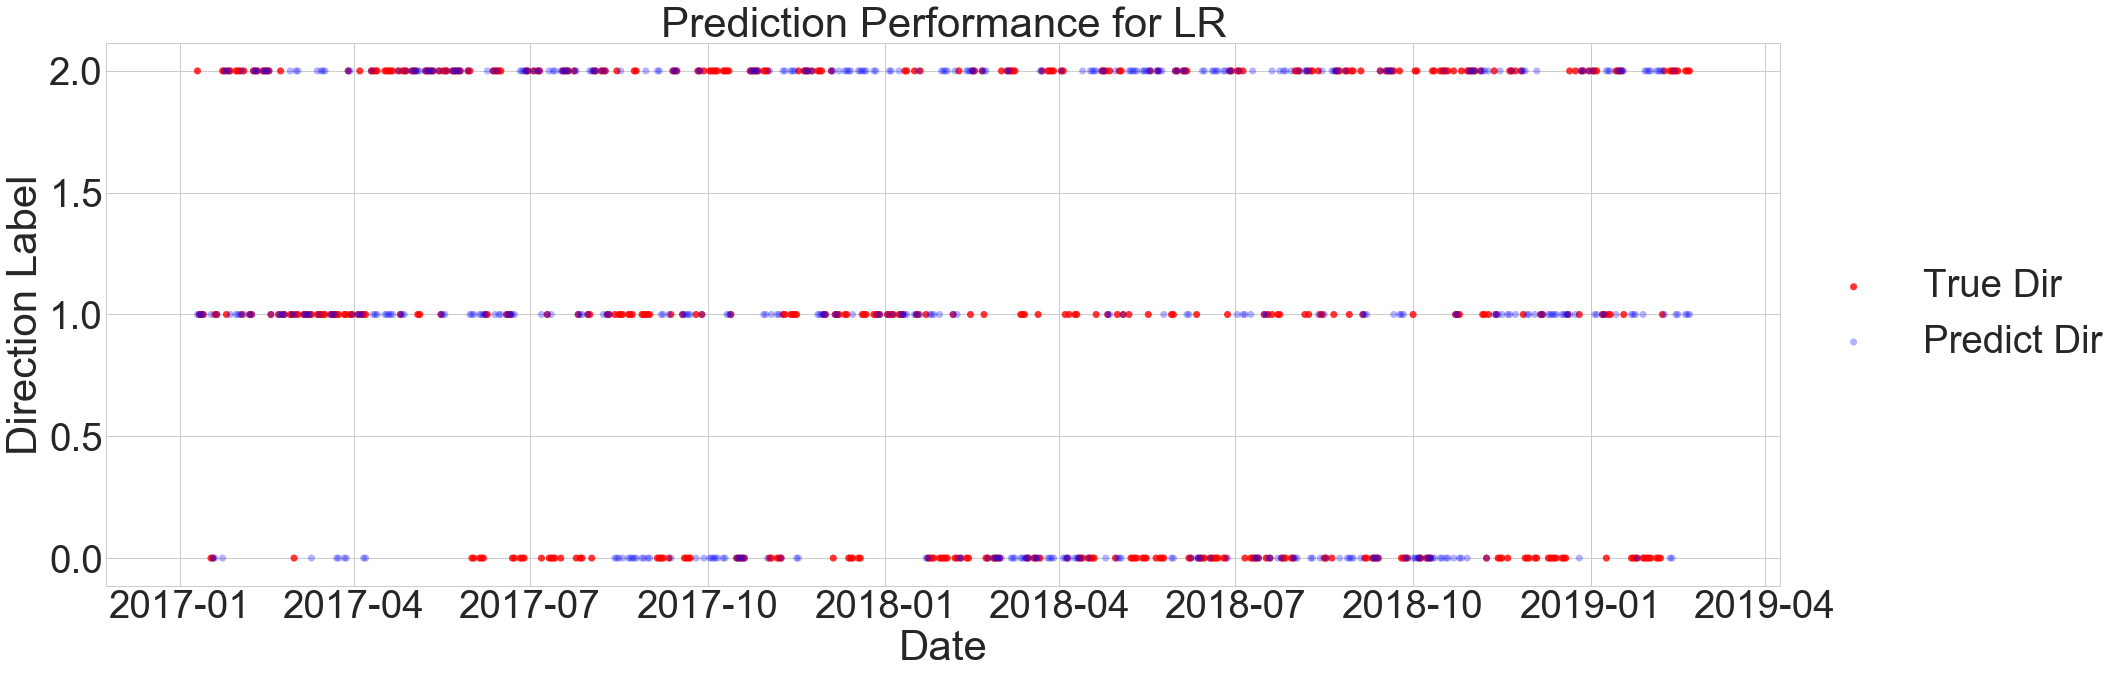

  Model  Accuracy  Precision    Recall    F1wght   F1micro
0    LR  0.394737   0.391609  0.394737  0.391659  0.394737


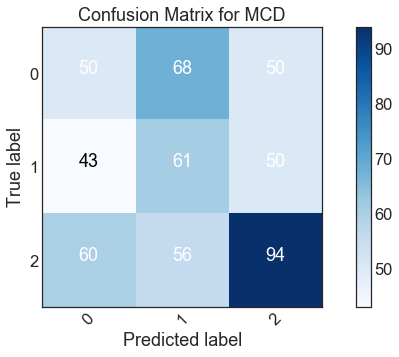

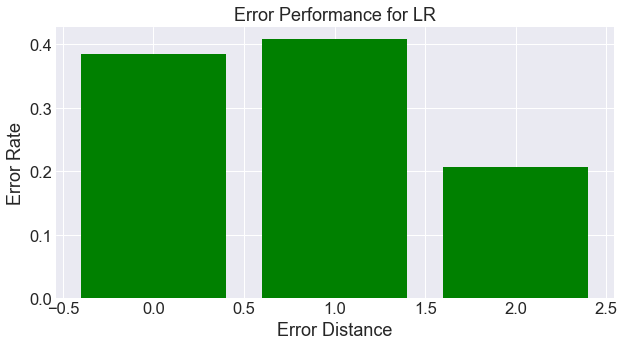

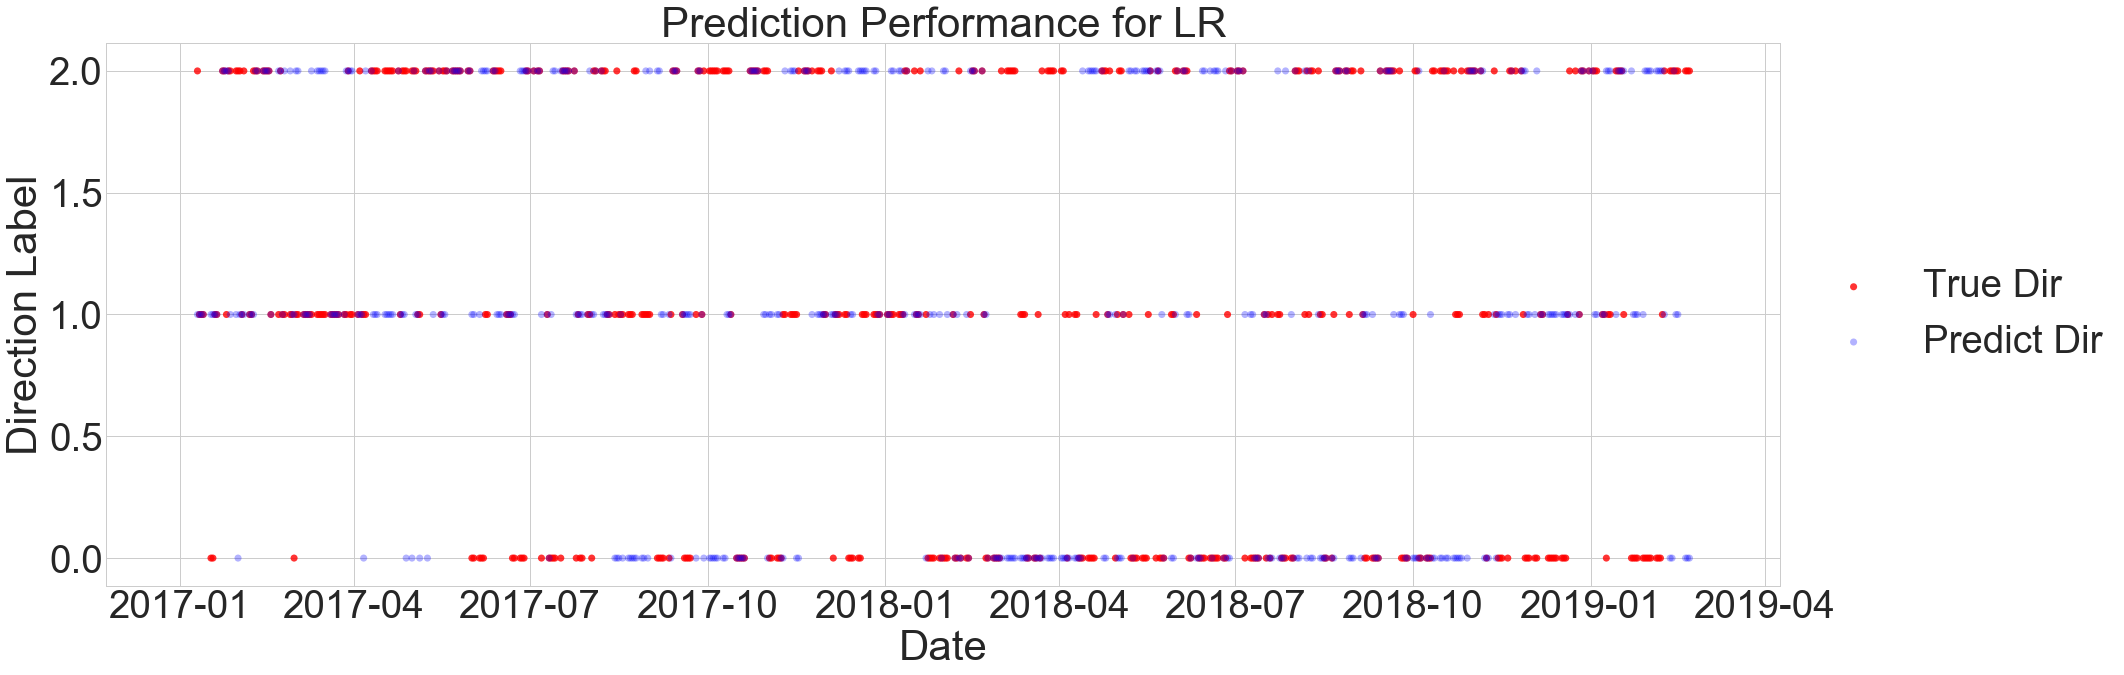

  Model  Accuracy  Precision    Recall    F1wght   F1micro
0    LR  0.385338   0.389911  0.385338  0.386243  0.385338


In [11]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "MCD"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=6) # training history window 
MODEL_NAME = 'LR'

selected_MCD_tech_factors = MCD_tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 
                                                'One-Month Change in Average Daily Share Turnover',
                                                'MACD Signal']]

selected_MCD_tech_news_factors = MCD_tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 
                                                'One-Month Change in Average Daily Share Turnover', 'Daily Media Sentiment Indicator', 
                                                'MACD Signal']]


MCD_tech_df = generate_NDayReturn(selected_MCD_tech_factors, ticker_name, start_date, end_date, pred_day)
MCD_tech_news_df = generate_NDayReturn(selected_MCD_tech_news_factors, ticker_name, start_date, end_date, pred_day)

y_true, y_pred_tech, test_dates = model_testing(MCD_tech_df, test_date_start, history_window, pred_day, MODEL_NAME)
y_true, y_pred_news, test_dates = model_testing(MCD_tech_news_df, test_date_start, history_window, pred_day, MODEL_NAME)


perform_without_news = model_performance(y_true, y_pred_tech, 'without news')
perform_with_news =model_performance(y_true, y_pred_news, 'with news')
result = pd.concat([perform_without_news, perform_with_news])
result

performance_with_news = model_evalutation(y_true, y_pred_news, test_dates, MODEL_NAME)
performance_without_news = model_evalutation(y_true, y_pred_tech, test_dates, MODEL_NAME)

In [12]:
result

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,without news,0.385338,0.389911,0.385338,0.386243,0.385338
0,with news,0.394737,0.391609,0.394737,0.391659,0.394737


### **History Window Test for LR**

In [ ]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "MCD"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=7) # training history window 
MODEL_NAME = 'LR'

MCD_tech_df = generate_NDayReturn(selected_MCD_tech_factors, ticker_name, start_date, end_date, pred_day)


def history_window_test(tech_df, test_date_start, model_name):
    history_windows = list(range(1, 16))
    accuracies = []
    
    for hw in history_windows:
        history_window = relativedelta(years=hw) # training history window 
        y_true, y_pred, test_dates =model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        accuracy = accuracy_score(y_true, y_pred)
        print('history_window: {h} year\t acc: {a:.3f}'.format(h=hw, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(history_windows, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Histroy Window Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Years')
    plt.show()

history_window_test(MCD_tech_df, test_date_start, MODEL_NAME) 

### **Rolliing Window Test for Price Trends for MCD**

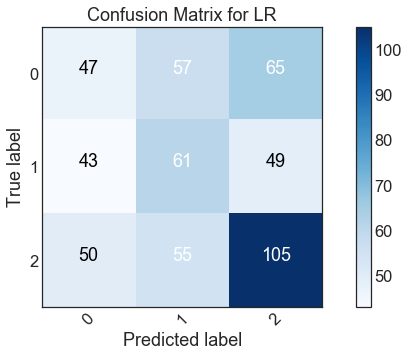

One-Week Daily Price Trend 	 acc: 0.400


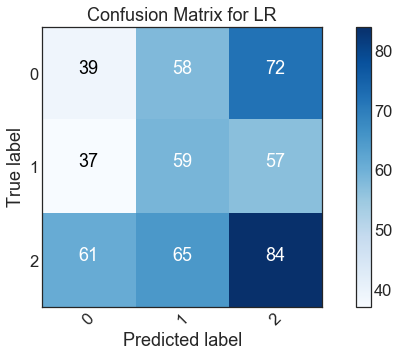

One-Month Daily Price Trend 	 acc: 0.342


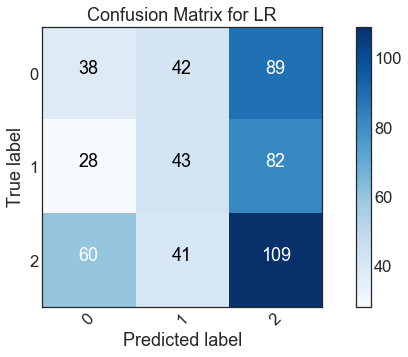

Three-Month Daily Price Trend 	 acc: 0.357


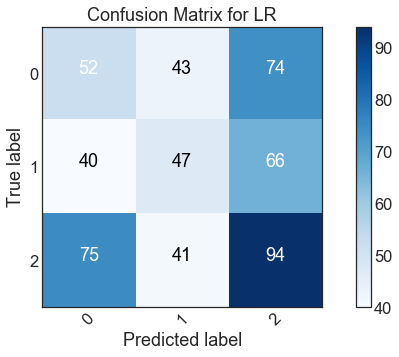

Nine-Month Daily Price Trend 	 acc: 0.363


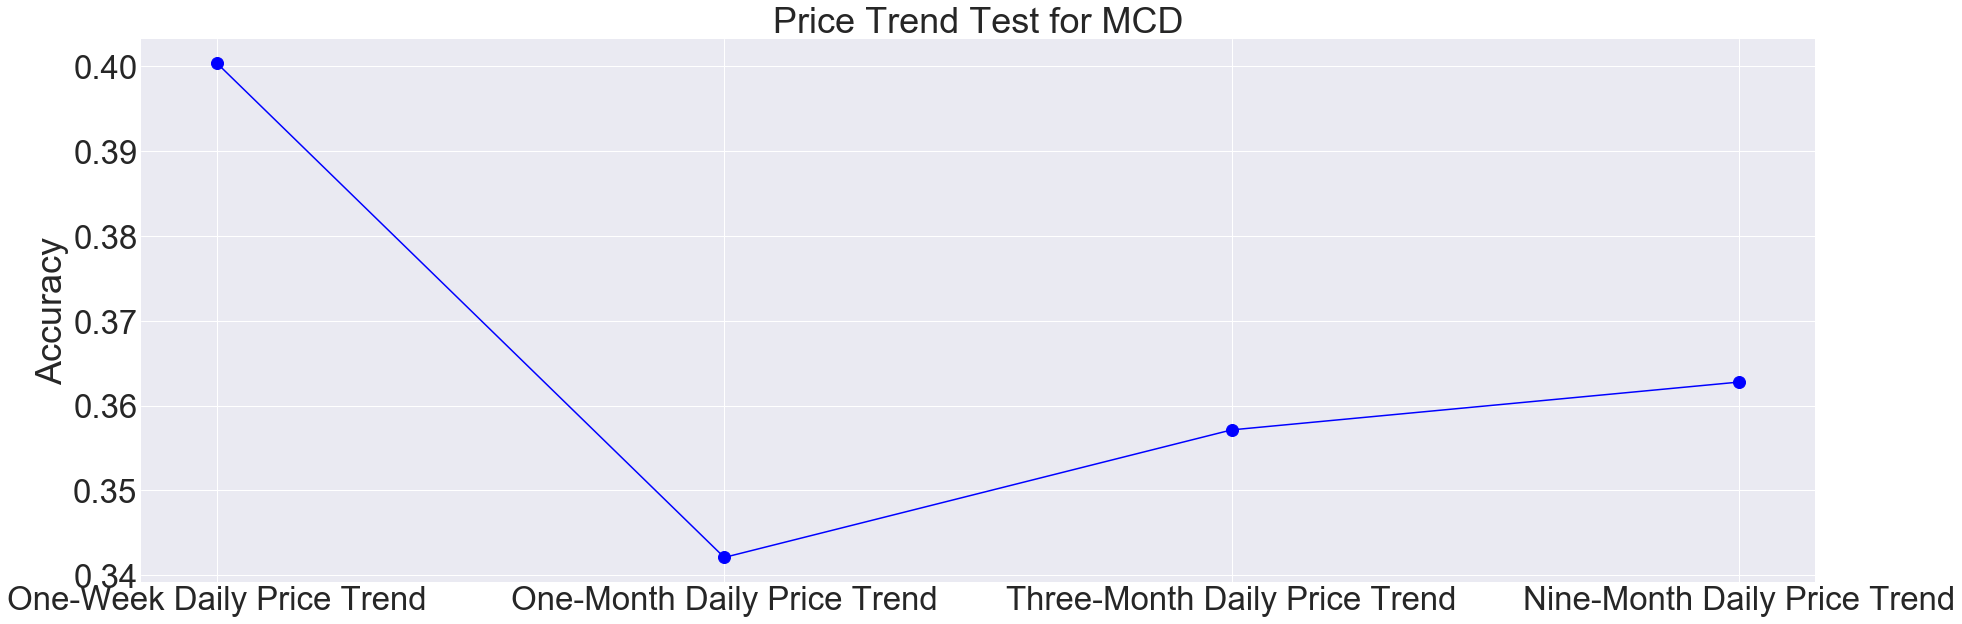

In [46]:
start_date = datetime.datetime(2000, 1, 3)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "MCD"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=6) # training history window 
MODEL_NAME = 'LR'

def price_trend_test(tech_factor_df, test_date_start, model_name):
    price_trend = ['One-Week Daily Price Trend', 'One-Month Daily Price Trend', 'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend']
    accuracies = []
    
    for pt in price_trend: 
        selected_tech_factors = tech_factor_df[[pt, 'Relative Strength Index', 
                                                'One-Month Change in Average Daily Share Turnover', 'Daily Media Sentiment Indicator', 
                                                'MACD Signal']]
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pred_day)
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(model_name))
        accuracy = accuracy_score(y_true, y_pred)
        print('{p} \t acc: {a:.3f}'.format(p=pt, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(price_trend, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Price Trend Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
#     plt.xlabel('Days')
    plt.show()

price_trend_test(MCD_tech_factor_df, test_date_start, MODEL_NAME) 

### **Predict Day Test for MCD**

predict day: 1 days	 acc: 0.323


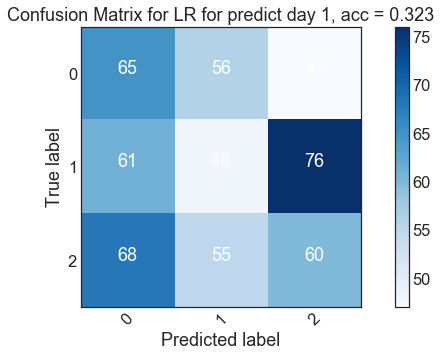

predict day: 2 days	 acc: 0.333


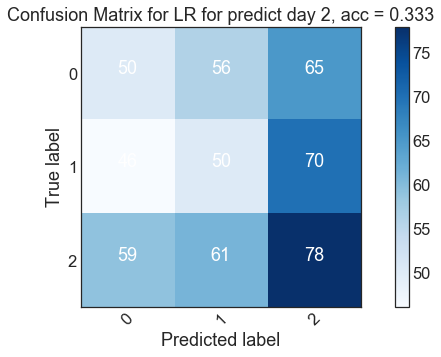

predict day: 3 days	 acc: 0.371


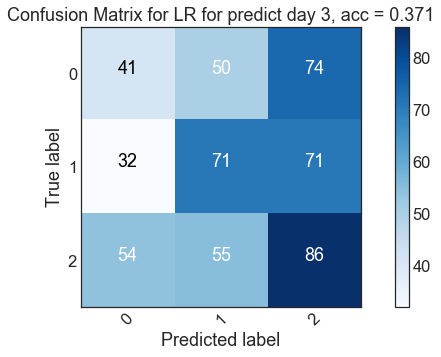

predict day: 4 days	 acc: 0.347


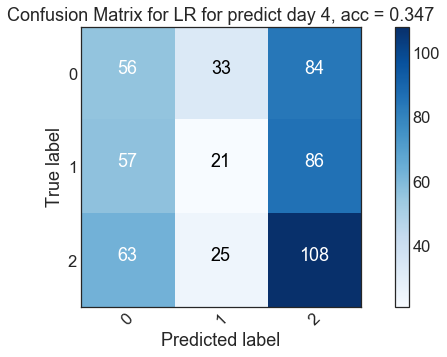

predict day: 5 days	 acc: 0.400


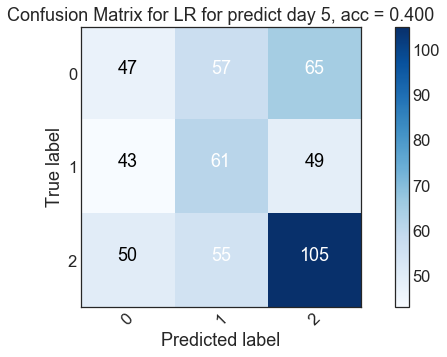

predict day: 10 days	 acc: 0.368


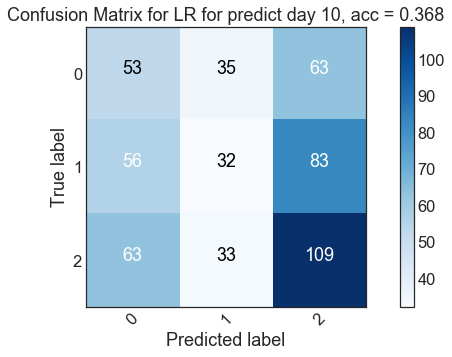

predict day: 15 days	 acc: 0.335


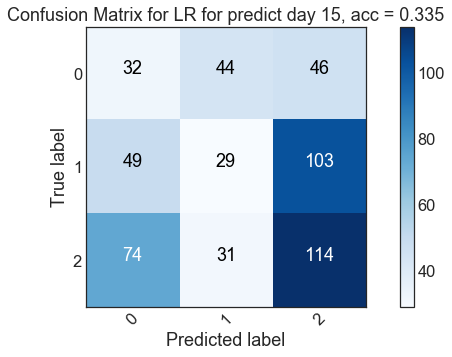

predict day: 20 days	 acc: 0.308


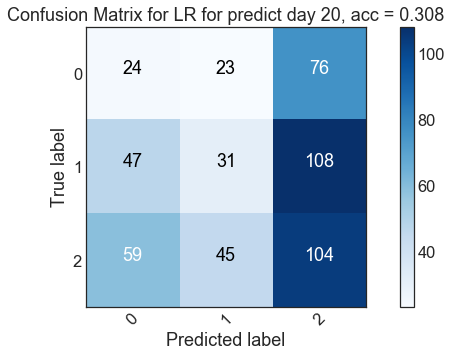

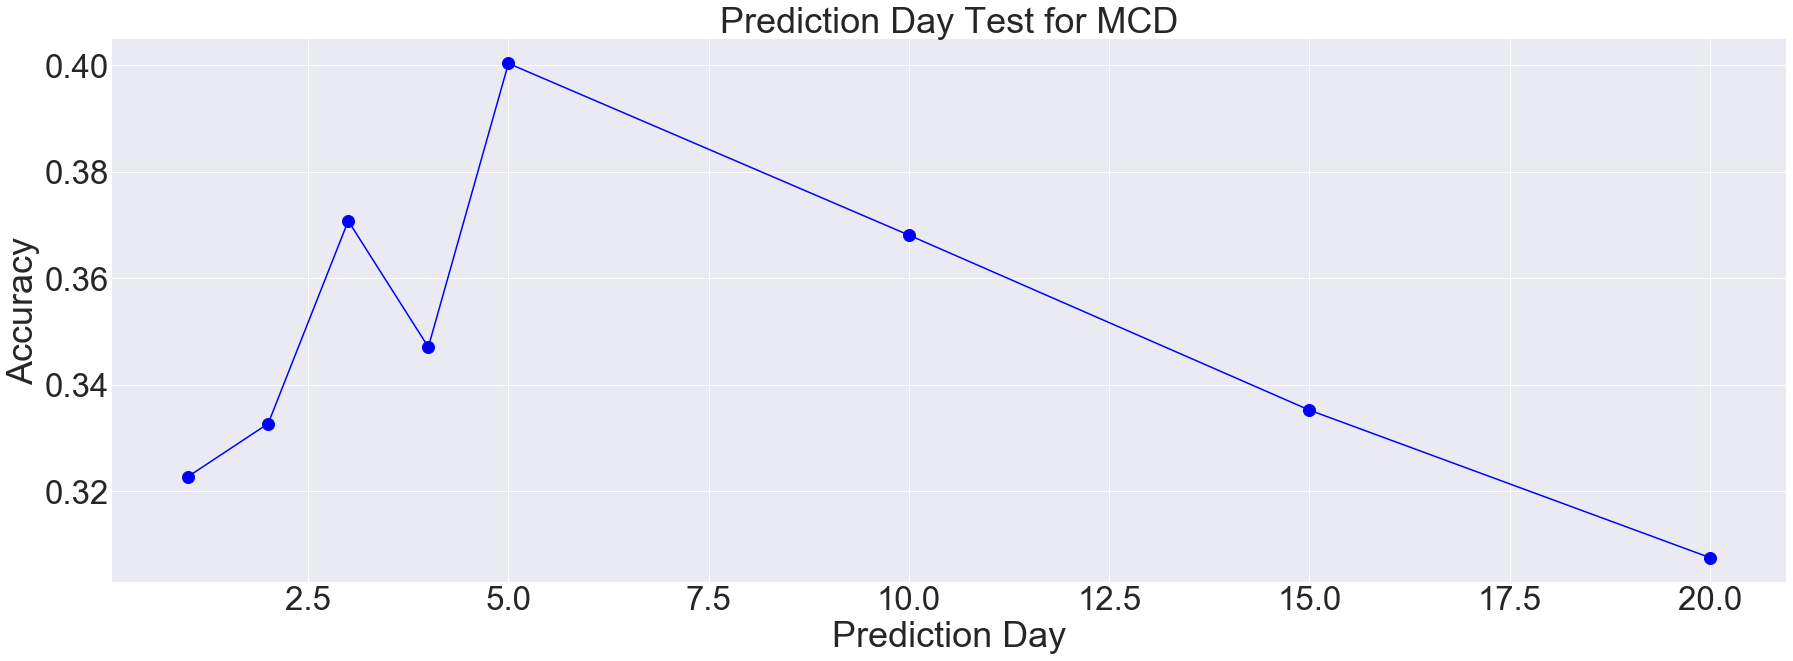

In [48]:
history_window = relativedelta(years=6) # training history window 

def prediction_day_thresholds_test(selected_tech_factors, model_name):
    pred_days = [1, 2, 3, 4, 5, 10, 15, 20]
    accuracies = []                           
    for pd in pred_days: 
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pd)    
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pd, model_name)
        accuracy = accuracy_score(y_true, y_pred) 
        print('predict day: {p} days\t acc: {a:.3f}'.format(p=pd, a=accuracy))
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {n} for predict day {p}, acc = {a:.3f}'.format(n=model_name, p=pd, a=accuracy ))
        accuracies.append(accuracy)
    
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(pred_days, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Prediction Day Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction Day')
    plt.show()

prediction_day_thresholds_test(selected_MCD_tech_factors, MODEL_NAME)